In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

from tqdm import tqdm

In [2]:
class GR4J(nn.Module):

    def __init__(self, s_init=0, r_init=0):
        super(GR4J, self).__init__()
        self.s_init = s_init
        self.r_init = r_init
        self.x1 = torch.tensor(109.37118080390698)#dist.uniform.Uniform(100, 1200).sample()
        self.h1 = nn.Linear(4, 32)
        self.h2 = nn.Linear(32, 16)
        self.h3 = nn.Linear(16, 4)
        self.o = nn.Linear(4, 1)

    
    def forward(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(prec - etp)
        e_n = torch.relu(etp - prec)

        # Production store
        num_timesteps = len(prec)
        p_s = torch.zeros(num_timesteps)
        e_s = torch.zeros(num_timesteps)
        perc = torch.zeros(num_timesteps)
        s_store = torch.zeros(num_timesteps + 1)
        s_store[0] = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s[t] = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n[t]/x1)) /
                (1 + s_store[t-1] / x1 * torch.tanh(p_n[t] / x1)))

            # from the production store (eq. 4)
            e_s[t] = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(e_n[t]/x1)) 
                / (1 + (1 - s_store[t-1] / x1) * torch.tanh(e_n[t] / x1)))

            s_store[t] = s_store[t - 1] + p_s[t] - e_s[t]

            # calculate percolation from actual storage level
            perc[t] = s_store[t] * (1 - (1 + (4/9 * s_store[t] / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store[t] = s_store[t] - perc[t]

        # Expand dim
        p_n = p_n[:, None]
        e_n = e_n[:, None]
        p_s = p_s[:, None] 
        perc = perc[:, None]
        
        # Concatenate
        inp = torch.concat([p_n, e_n, p_s, perc], dim=1)

        # ANN
        out = self.h1(inp.float())
        out = torch.relu(self.h3(self.h2(out)))
        out = torch.relu(self.o(out)).flatten()

        return out

In [3]:
data_location = os.path.join('/data')

In [4]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [5]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [6]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [7]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values.astype('float32'))
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values.astype('float32'))
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values.astype('float32'))
date_calib = calibration_data.loc[:, 'Date'].values


In [8]:
def nse(targets, predictions):
    return 1-(torch.sum((targets-predictions)**2)/torch.sum((targets-torch.mean(targets))**2))

def nnse(targets, predictions):
    return 1/(2 - nse(targets, predictions))

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model(prcp, et)

    nse_score = nse(flow, flow_pred)
    nnse_score = nnse(flow, flow_pred)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow.detach().numpy(), color='black', label='obs', alpha=0.8)
    ax.plot(dates, flow_pred.detach().numpy(), color='red', label='pred', alpha=1.0)
    ax.plot(dates, prcp.detach().numpy(), 'g--', label='precip', alpha=0.45)
    ax.plot(dates, et.detach().numpy(), 'y--', label='etp', alpha=0.45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

In [9]:
model = GR4J()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
result = model(prec=prcp_calib, etp=et_calib)
result

tensor([0.1007, 0.1019, 0.1119,  ..., 0.0382, 0.0778, 0.0832],
       grad_fn=<ReshapeAliasBackward0>)

In [11]:
N = 200

pbar = tqdm(range(N))

for epoch in pbar:

    opt.zero_grad()

    pred_flow = model(prcp_calib, et_calib)

    loss = torch.nn.functional.mse_loss(flow_calib, pred_flow)

    loss.backward()

    opt.step()

    pbar.set_description(f"Epoch {epoch+1} loss: {loss.detach().numpy():.4f}")

Epoch 200 loss: 28.4086: 100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


NSE: 0.001
Normalized NSE: 0.500


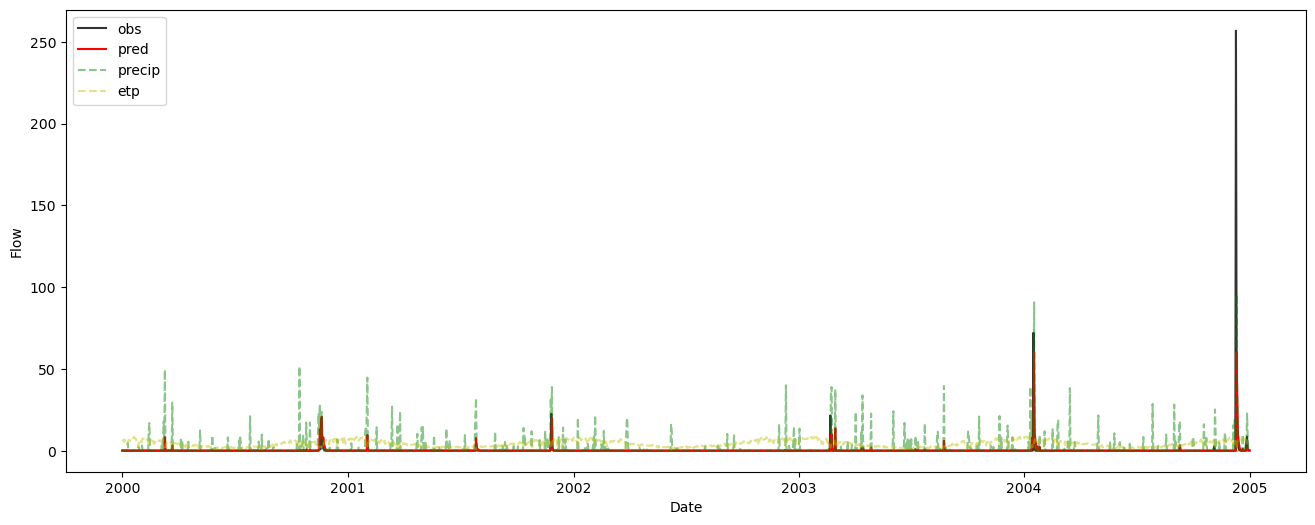

In [13]:
# Evaluate on unseen data
prcp_holdout = torch.from_numpy(holdout_data.loc[:, 'Rain'].values)
et_holdout= torch.from_numpy(holdout_data.loc[:, 'FAO56'].values)
flow_holdout = torch.from_numpy(holdout_data.loc[:, 'Value'].values)
date_holdout = holdout_data.loc[:, 'Date'].values

evaluate(model, date_holdout, et_holdout, prcp_holdout, flow_holdout)